In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Replace the paths with the actual path to your zip file and the destination folder
zip_file_path = "/content/drive/MyDrive/Flickr 8k/archive (12).zip"
destination_folder = "/content/drive/MyDrive/Flickr 8k/Dataset"

In [ ]:
# Now, use the `unzip` command to extract the files
!unzip "$zip_file_path" -d "$destination_folder"

In [41]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [42]:
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [4]:
import os

# Define the paths to the text file and the images folder
text_file_path = "/content/drive/MyDrive/Flickr 8k/Dataset/captions.txt"
images_folder_path = "/content/drive/MyDrive/Flickr 8k/Dataset/Images"

# Open the text file and read the contents
with open(text_file_path, "r") as f:
    contents = f.readlines()

# Open a new file for writing
with open(text_file_path, "w") as f:
    # Initialize a counter for deleted images
    deleted_images_count = 0
    
    # Iterate through each line in the text file
    for line in contents:
        # Split the line into a list using comma as the delimiter
        parts = line.strip().split(",")
        
        # Extract the first element as the image filename and the rest as the caption
        image_filename = parts[0]
        caption = ",".join(parts[1:])
        
        # Check if the image file exists in the images folder
        if os.path.exists(os.path.join(images_folder_path, image_filename)):
            # Write the line to the new file
            f.write(line)
        else:
            # Increment the counter for deleted images
            deleted_images_count += 1
            # Print a message indicating that the image was not found
            print(f"{image_filename} does not exist in the images folder and has been removed from {text_file_path}")

    # Print the count of deleted images
    print(f"{deleted_images_count} images have been deleted from {text_file_path}")

image does not exist in the images folder and has been removed from /content/drive/MyDrive/Flickr 8k/Dataset/captions.txt
1 images have been deleted from /content/drive/MyDrive/Flickr 8k/Dataset/captions.txt


In [43]:
image_path = '/content/drive/MyDrive/Flickr 8k/Dataset/Images'

In [44]:
import os

image_path = "/content/drive/MyDrive/Flickr 8k/Dataset/Images"

num_images = len([f for f in os.listdir(image_path) if f.endswith('.jpg')])

print(f"There are {num_images} images in {image_path}")

There are 7993 images in /content/drive/MyDrive/Flickr 8k/Dataset/Images


In [45]:
data = pd.read_csv("/content/drive/MyDrive/Flickr 8k/Dataset/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [46]:
print(f"There are {len(data)} entries in the DataFrame")

There are 39965 entries in the DataFrame


In [47]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [48]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [49]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
from keras.preprocessing.text import Tokenizer
import pickle

# Create a tokenizer
num_words = 10000  # Adjust this based on the size of your vocabulary
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Fit the tokenizer on your captions
captions = data['caption'].tolist()
tokenizer.fit_on_texts(captions)

# Save the tokenizer to Google Drive
tokenizer_path = "/content/drive/MyDrive/Flickr 8k/Dataset/tokenizer.pkl"

with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
    
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 313, 63, 195, 119, 2]

In [16]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 4s 0us/step


100%|██████████| 7993/7993 [17:01<00:00,  7.83it/s]


In [17]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [18]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [19]:
from tensorflow.keras.utils import plot_model

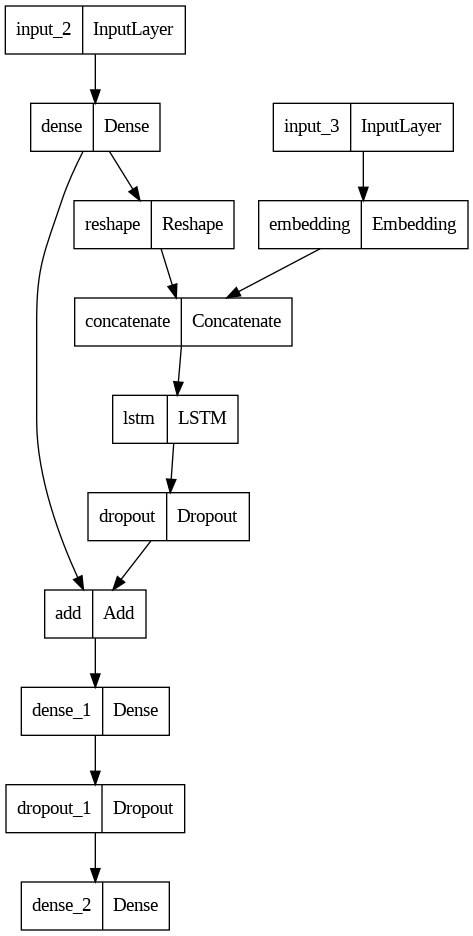

In [20]:
plot_model(caption_model)

In [21]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [22]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [23]:
model_name = "/content/drive/MyDrive/Flickr 8k/Dataset/model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [24]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
530/530 [==============================] - ETA: 0s - loss: 5.1712
Epoch 1: val_loss improved from inf to 4.29884, saving model to /content/drive/MyDrive/Flickr 8k/Dataset/model.h5
530/530 [==============================] - 255s 469ms/step - loss: 5.1712 - val_loss: 4.2988 - lr: 0.0010
Epoch 2/50
530/530 [==============================] - ETA: 0s - loss: 4.2250
Epoch 2: val_loss improved from 4.29884 to 3.96163, saving model to /content/drive/MyDrive/Flickr 8k/Dataset/model.h5
530/530 [==============================] - 60s 114ms/step - loss: 4.2250 - val_loss: 3.9616 - lr: 0.0010
Epoch 3/50
530/530 [==============================] - ETA: 0s - loss: 3.9591
Epoch 3: val_loss improved from 3.96163 to 3.82526, saving model to /content/drive/MyDrive/Flickr 8k/Dataset/model.h5
530/530 [==============================] - 51s 95ms/step - loss: 3.9591 - val_loss: 3.8253 - lr: 0.0010
Epoch 4/50
530/530 [==============================] - ETA: 0s - loss: 3.7970
Epoch 4: val_loss improved 

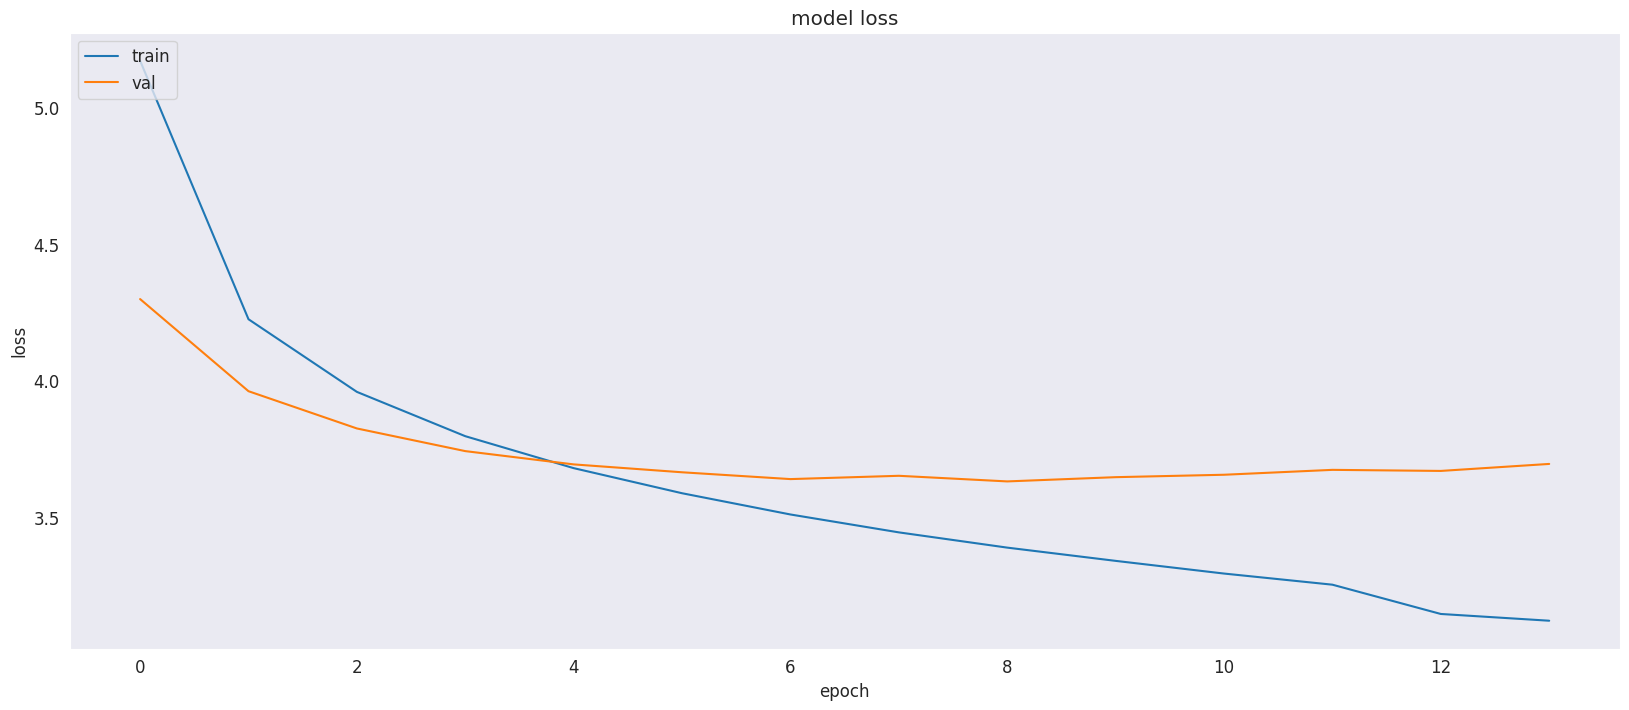

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()